## Import libraries and import data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table

from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

In [4]:
market = load_data("Smarket")

## Short look into the data

In [5]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   int64   
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 79.6 KB


In [6]:
market.isnull().sum()

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

In [7]:
market.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


<Axes: >

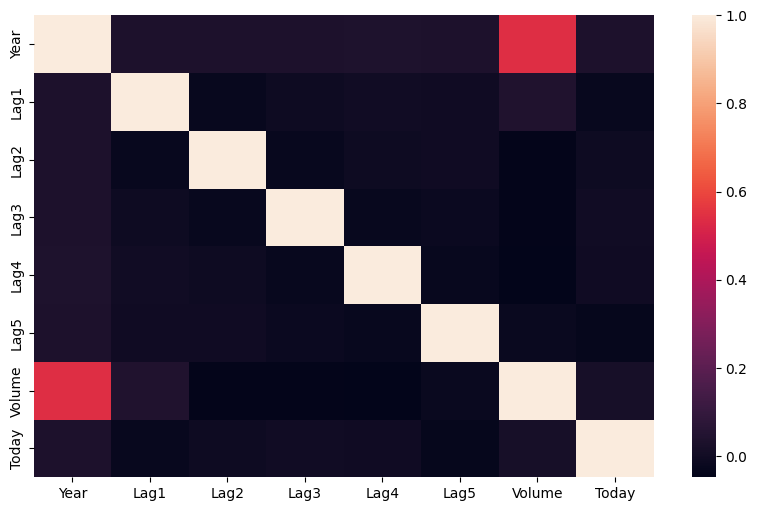

In [8]:
fig, sub = plt.subplots(1,1, figsize=(10, 6))

sns.heatmap(market.drop("Direction", axis = 1).corr(), ax = sub)

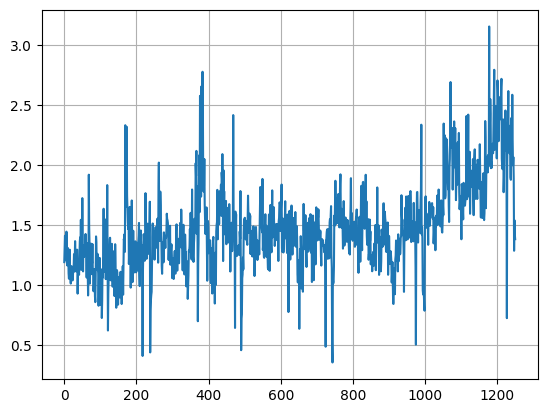

In [9]:
market["Volume"].plot()
plt.grid()

## Logistic Regression

In [10]:
all_vars  = market.columns.drop(["Today", "Direction", "Year"])
design = MS(all_vars)

X = design.fit_transform(market)
y = market.Direction == "Up"

glm = sm.GLM(
    endog = y,
    exog = X,
    family=sm.families.Binomial()
    )

results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Wed, 25 Jun 2025   Deviance:                       1727.6
Time:                        12:25:24   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1260      0.241     -0.523      0.6

* lowest p-val at lag1 
* but: p-val around 0.15 so there's no clear evidence that there's a real association between lag1 and direction

In [11]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [12]:
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"

In [13]:
pd.DataFrame(data = confusion_matrix(y_true=labels, y_pred = market.Direction), index = ["Truth: Down", "Truth: Up"], columns = ["Predicted: Down", "Predicted: Up"])

,Predicted: Down,Predicted: Up
Truth: Down,145,141
Truth: Up,457,507


In [14]:
(507+145)/1250, np.mean(labels == market.Direction)

(0.5216, np.float64(0.5216))

* Training error rate: 1 - 0.522 = 0.478

In [15]:
train = market["Year"] < 2005
market_train = market.loc[train]
market_test = market.loc[~train]

market_test.shape

(252, 9)

In [16]:
X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]

glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())

results = glm_train.fit()
probs = results.predict(exog = X_test)

In [17]:
D = market["Direction"]
L_train , L_test = D.loc[train], D.loc[~train]

labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"

In [18]:
pd.DataFrame(data = confusion_matrix(y_true=L_test, y_pred = labels), index = ["Truth: Down", "Truth: Up"], columns = ["Predicted: Down", "Predicted: Up"])

,Predicted: Down,Predicted: Up
Truth: Down,77,34
Truth: Up,97,44


In [19]:
np.mean(labels == L_test), np.mean(labels != L_test)

(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

* Test error rate: 52 % 

**Refitting the model with less variables** 

In [20]:
model = MS(["Lag1", "Lag2"]).fit(market)
X = model.transform(market)

X_train, X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())

results = glm_train.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.70
Date:                Wed, 25 Jun 2025   Deviance:                       1381.4
Time:                        12:25:24   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001865
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0322      0.063      0.508      0.6

In [21]:
probs = results.predict(exog = X_test)
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"

pd.DataFrame(data = confusion_matrix(y_true=L_test, y_pred = labels), index = ["Truth: Down", "Truth: Up"], columns = ["Predicted: Down", "Predicted: Up"])

,Predicted: Down,Predicted: Up
Truth: Down,35,76
Truth: Up,35,106


In [22]:
(35+106) / 252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

## Linear Discriminant Analysis

In [23]:
X_train, X_test = [M.drop(columns = ["intercept"], axis = 1) for M in [X_train, X_test]]

In [24]:
X_train.head()

,Lag1,Lag2
0,0.381,-0.192
1,0.959,0.381
2,1.032,0.959
3,-0.623,1.032
4,0.614,-0.623


In [25]:
lda = LDA(store_covariance=True)
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [26]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

* The lda.means_ return a matrix of shape (n_classes, n_features)
* For class 0 (market decreases), the returns of Lag1 and Lag2 have the tendency to be positive | Lag1: 0.0427, Lag2: 0.03389
* For class 1 (market increases), the returns of Lag1 and Lag2 have the tendency to be negative | Lag1: -0.0395, Lag2: -0.0313

In [27]:
#class 0 and class 1
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [28]:
#priors 
lda.priors_

array([0.49198397, 0.50801603])

In [29]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

* LDA decision rule: <br>
$-0.64 * Lag1 - 0.51 * Lag2$

--> if the result of this equation turns out to be large, the LDA classifier will predict a market increase and if it's small the LDA classifier predicts a market decline

In [30]:
lda_pred = lda.predict(X_test)

In [31]:
pd.DataFrame(data = confusion_matrix(y_true=L_test, y_pred = lda_pred), index = ["Truth: Down", "Truth: Up"], columns = ["Predicted: Down", "Predicted: Up"])

,Predicted: Down,Predicted: Up
Truth: Down,35,76
Truth: Up,35,106


## Quadratic Discriminant Analysis

In [32]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [33]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

Estimated Covariance in the first class

In [34]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [35]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [36]:
np.mean(qda_pred == L_test)

np.float64(0.5992063492063492)

## Naive Bayes

In [37]:
NB = GaussianNB()
NB.fit(X_train, L_train)

,priors,None
,var_smoothing,1e-09


In [38]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [39]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [40]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])